# Convolution

Im Folgenden wird die Convolution an einem Beispiel erläutert. Dazu lesen wir ein Bild ein:

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/datasets/base.py:762: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  images = [imread(filename) for filename in filenames]
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/datasets/base.py:762: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  images = [imread(filename) for filename in filenames]


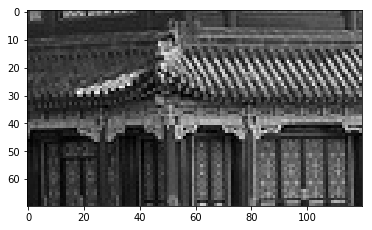

In [2]:
import numpy as np
from sklearn.datasets import load_sample_image
import matplotlib.pyplot as plt
china = load_sample_image("china.jpg")
image = china[150:220, 130:250]
height, width, channels = image.shape
image_grayscale = image.mean(axis=2).astype(np.float32)

image_grayscale = image_grayscale.reshape(1, height, width, 1)

plt.imshow(image_grayscale[0,:,:,0],cmap='gray')
plt.show()

Wir erzeugen einen Filter mit einer horizontalen Linie:

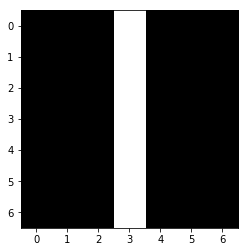

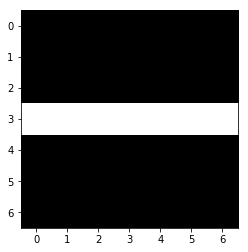

In [3]:
fmap = np.zeros(shape=(7, 7, 1, 2), dtype=np.float32)
fmap[:, 3, 0, 0] = 1
fmap[3, :, 0, 1] = 1
plt.imshow(fmap[:,:,0,0],cmap='gray')
plt.show()
plt.imshow(fmap[:,:,0,1],cmap='gray')
plt.show()


Tensorflow implementieren und die Faltung ausführen:

In [5]:
import tensorflow as tf
X = tf.placeholder(tf.float32, shape=(1, height, width, 1))
feature_maps = tf.constant(fmap)
convolution = tf.nn.conv2d(X, feature_maps, strides=[1,5,5,1], padding="SAME")
with tf.Session() as sess:
    output = convolution.eval(feed_dict={X: image_grayscale})

Ergebnis der Faltung anzeigen:

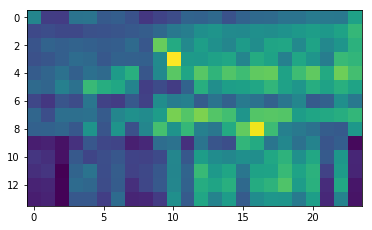

In [6]:
plt.imshow(output[0,:,:,0])
plt.show()

In [7]:
height = 28
width = 28
channels = 1
n_inputs = height * width

conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 2
conv2_pad = "SAME"

pool3_fmaps = conv2_fmaps

n_fc1 = 64
n_outputs = 10

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad)
conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad)
with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 7 * 7])

with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat, n_fc1)

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs)
    Y_proba = tf.nn.softmax(logits)

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()


In [9]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")


Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [10]:
n_epochs = 10
batch_size = 100

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

        save_path = saver.save(sess, "./my_mnist_model")

0 Train accuracy: 0.97 Test accuracy: 0.9736
1 Train accuracy: 1.0 Test accuracy: 0.9818
2 Train accuracy: 1.0 Test accuracy: 0.9772
3 Train accuracy: 1.0 Test accuracy: 0.9796
4 Train accuracy: 0.98 Test accuracy: 0.9821
5 Train accuracy: 1.0 Test accuracy: 0.9827
6 Train accuracy: 0.99 Test accuracy: 0.9807
7 Train accuracy: 1.0 Test accuracy: 0.9813
8 Train accuracy: 1.0 Test accuracy: 0.9789
9 Train accuracy: 1.0 Test accuracy: 0.9803


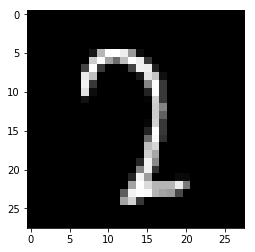

In [30]:
number = 10127
plt.imshow(np.reshape(mnist.train.images[number,:],[28,28]),cmap='gray')
plt.show()

In [29]:
with tf.Session() as sess:
    saver.restore(sess,"./my_mnist_model")
    Z = logits.eval(feed_dict={X: np.reshape(mnist.train.images[number,:],[1,784])})
    y_pred = np.argmax(Z)
    print(y_pred)

INFO:tensorflow:Restoring parameters from ./my_mnist_model
2
